In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/week6')

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.14MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 121kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.16MB/s]


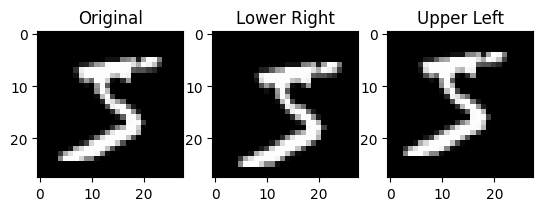

In [3]:
# --- IMPORTS ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONSTANTS ---
C = 1          # MNIST has 1 channel
filters = 16   # Often used for MNIST CNN examples
D = 28         # Original MNIST width/height
B = 64         # Batch size
classes = 10   # MNIST has 10 classes
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- LOAD MNIST (no augmentation here) ---
mnist_data_train = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transforms.ToTensor()
)
mnist_data_test = torchvision.datasets.MNIST(
    "./data", train=False, transform=transforms.ToTensor()
)

mnist_train_loader = DataLoader(mnist_data_train, shuffle=True, batch_size=B)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

# --- PICK SAMPLE AND SHIFT IT ---
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0, :]

img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray'); axarr[0].set_title("Original")
axarr[1].imshow(img_lr, cmap='gray'); axarr[1].set_title("Lower Right")
axarr[2].imshow(img_ul, cmap='gray'); axarr[2].set_title("Upper Left")
plt.show()

# --- PREDICTION FUNCTION ---
def pred(model, img):
    with torch.no_grad():
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        w, h = img.shape
        x = img.reshape(1, 1, w, h).float()
        logits = model(x)
        y_hat = F.softmax(logits, dim=1)
        return y_hat.numpy().flatten()


In [4]:
# model_cnn_pool = nn.Sequential(
#     nn.Conv2d(C, filters, 3, padding=1),
#     nn.Tanh(),
#     nn.Conv2d(filters, filters, 3, padding=1),
#     nn.Tanh(),
#     nn.Conv2d(filters, filters, 3, padding=1),
#     nn.Tanh(),
#     nn.MaxPool2d(2),

#     nn.Conv2d(filters, 2*filters, 3, padding=1),
#     nn.Tanh(),
#     nn.Conv2d(2*filters, 2*filters, 3, padding=1),
#     nn.Tanh(),
#     nn.Conv2d(2*filters, 2*filters, 3, padding=1),
#     nn.Tanh(),
#     nn.MaxPool2d(2),

#     nn.Flatten(),
#     nn.Linear(2*filters * D//(4**2), classes)
# ).to(device)


In [5]:
def train_simple_network(model, loss_func, train_loader, test_loader,
                         score_funcs, device, epochs=20):

    results = []

    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_func(logits, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # --- Evaluation ---
        model.eval()
        with torch.no_grad():
            all_preds = []
            all_labels = []
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                preds = torch.argmax(logits, 1)
                all_preds.append(preds.cpu())
                all_labels.append(y.cpu())

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        scores = {name: fn(all_labels, all_preds) for name, fn in score_funcs.items()}
        scores["epoch"] = epoch + 1
        results.append(scores)

    return results


In [6]:
loss_func = nn.CrossEntropyLoss()

# Redefine model_cnn_pool with the corrected linear layer input size
# The input features to the nn.Linear layer should be 2*filters * (D//4) * (D//4)
# D=28, filters=16, so 2*16*(28//4)*(28//4) = 32*7*7 = 1568
model_cnn_pool = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=1),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=1),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Conv2d(filters, 2*filters, 3, padding=1),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=1),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(2 * filters * (D // 4) * (D // 4), classes)
).to(device)

cnn_results_with_pool = train_simple_network(
    model_cnn_pool,
    loss_func,
    mnist_train_loader,
    test_loader=mnist_test_loader,
    score_funcs={"Accuracy": lambda y, p: (y == p).float().mean().item()},
    device=device,
    epochs=20
)

In [7]:
model_eval = model_cnn_pool.cpu().eval()

img_pred = pred(model_eval, img)
img_lr_pred = pred(model_eval, img_lr)
img_ul_pred = pred(model_eval, img_ul)

print("Original:", img_pred[correct_class])
print("Lower Right:", img_lr_pred[correct_class])
print("Upper Left:", img_ul_pred[correct_class])


Original: 0.9999293
Lower Right: 0.99413186
Upper Left: 0.99999845


In [8]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor()
])

test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST("./data", train=True,
                                           transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False,
                                          transform=test_transform)

mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,
                                  batch_size=B, num_workers=4)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=4)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
model_cnn_pool_aug = model_cnn_pool.__class__(*model_cnn_pool.children())
model_cnn_pool_aug = model_cnn_pool_aug.to(device)

cnn_results_with_pool_augmented = train_simple_network(
    model_cnn_pool_aug,
    loss_func,
    mnist_train_loader_t,
    test_loader=mnist_test_loader_t,
    score_funcs={"Accuracy": lambda y, p: (y == p).float().mean().item()},
    device=device,
    epochs=20
)


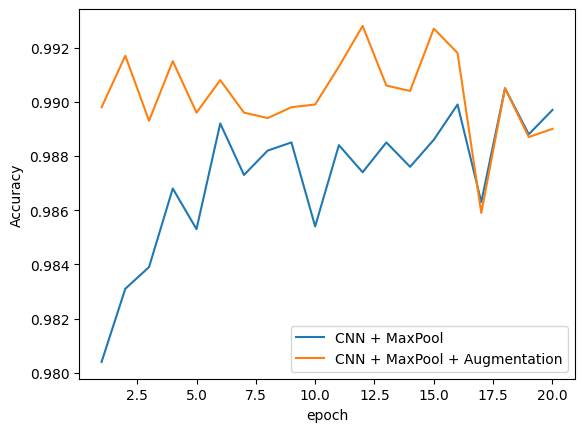

In [10]:
import pandas as pd

df1 = pd.DataFrame(cnn_results_with_pool)
df2 = pd.DataFrame(cnn_results_with_pool_augmented)

sns.lineplot(data=df1, x="epoch", y="Accuracy", label="CNN + MaxPool")
sns.lineplot(data=df2, x="epoch", y="Accuracy", label="CNN + MaxPool + Augmentation")
plt.show()
